<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a data-toc-modified-id="Align-and-annotate-reads-from-10X-single-cell-sequencing-of-influenza-infected-cells-1" href="#Align-and-annotate-reads-from-10X-single-cell-sequencing-of-influenza-infected-cells">Align and annotate reads from 10X single-cell sequencing of influenza-infected cells</a></span><ul class="toc-item"><li><span><a data-toc-modified-id="Set-up-1.1" href="#Set-up">Set up</a></span><ul class="toc-item"><li><span><a data-toc-modified-id="Modules,-programs,-directories-1.1.1" href="#Modules,-programs,-directories">Modules, programs, directories</a></span></li><li><span><a data-toc-modified-id="Samples-and-sequencing-runs-1.1.2" href="#Samples-and-sequencing-runs">Samples and sequencing runs</a></span></li></ul></li><li><span><a data-toc-modified-id="Build-the-reference-genome-1.2" href="#Build-the-reference-genome">Build the reference genome</a></span></li><li><span><a data-toc-modified-id="De-multiplex-the-deep-sequencing-reads-1.3" href="#De-multiplex-the-deep-sequencing-reads">De-multiplex the deep sequencing reads</a></span></li><li><span><a data-toc-modified-id="Align-the-reads-and-count-the-genes-per-cell-1.4" href="#Align-the-reads-and-count-the-genes-per-cell">Align the reads and count the genes per cell</a></span></li><li><span><a data-toc-modified-id="Annotate-synonymous-barcodes-on-the-influenza-reads-1.5" href="#Annotate-synonymous-barcodes-on-the-influenza-reads">Annotate synonymous barcodes on the influenza reads</a></span></li><li><span><a data-toc-modified-id="Build-merged-cell-gene-matrix-suitable-for-loading-into-Monocle-1.6" href="#Build-merged-cell-gene-matrix-suitable-for-loading-into-Monocle">Build merged cell-gene matrix suitable for loading into Monocle</a></span></li></ul></li></ul></div>

# Align and annotate reads from 10X single-cell sequencing of influenza-infected cells
This notebook processes the raw sequencing data from the 10X sequencing. 

The data are from A549 (human) cells infected with influenza at modest MOI, plus some MDCK (canine) cells that are **not** infected with virus and so serve as a lysis control.

The influenza viruses are a mix of a  _wildtype_ population and a _synonymously barcoded_ A/WSN/1933 (H1N1) virus.
The synonymously barcoded viruses have synonymous mutations near the 3' end of their mRNAs in order to enable them to be distinguished from the wildtype virus, thus quantifying the rate of cellular co-infection.

Much of the the data processing is done using the 10X software [cellranger](https://support.10xgenomics.com/single-cell/software/pipelines/latest/what-is-cell-ranger).
In some cases, custom scripts are used for non-standard steps relating to handling the influenza reads.

Specifically, this notebook performs the following operations:

   1. Builds a reference genome to which reads are aligned.
   2. De-multiplexes the reads using `cellranger`.
   3. Aligns the de-multiplexed reads to the reference genome to generate the cell-gene count matrix.
   4. Annotates the synonymous barcodes on the influenza reads.
   5. Gets all the results in a format that make them ready for downstream analysis with [Monocle](http://cole-trapnell-lab.github.io/monocle-release/).

## Set up 
First some basic set up for the analysis.

### Modules, programs, directories
Import modules used in this notebook, print information about program versions, and define created directories.
The [pymodules.utils](pymodules/utils.py) module contains custom functions used for this analysis.

In [1]:
import os
import collections
import multiprocessing
import shutil

from IPython.display import Image, display
import pymodules.utils

print("Using following version of cellranger:")
!cellranger count --version

resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
plotsdir = os.path.join(resultsdir, './plots/')
if not os.path.isdir(plotsdir):
    os.mkdir(plotsdir)
    
maxcpus = min(15, multiprocessing.cpu_count())  

Using following version of cellranger:
cellranger count (2.0.0)
Copyright (c) 2017 10x Genomics, Inc.  All rights reserved.
-------------------------------------------------------------------------------

 


### Samples and sequencing runs
For now we are just analyzing one sample, which is the MACS-sorted IFN+ cells collected at 13 hours.

In [2]:
samples = ['IFNenriched']

There were several sequencing runs. 
Below we define the relevant information for each run, referring to the location of the BCL files on the Hutch cluster.

In [3]:
# sequencing runs
seqruns = ['2017-03-14', '2017-07-21'] 

# BCLs on Hutch server for each run, flow cells extracted from BCL path
bcl_dir = '/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/' 
bcl_dirs = {
        '2017-03-14':os.path.join(bcl_dir, '170314_SN367_0883_AHJLLJBCXY.bcl'),
        '2017-07-21':os.path.join(bcl_dir, '170721_SN367_0961_BHNGGKBCXY'),
        }
# flow cell is last 9 letters of directory name
flow_cells = dict([
        (sample, os.path.splitext(os.path.basename(sampledir))[0][-9 : ])
            for (sample, sampledir) in bcl_dirs.items()
        ])

# sample sheets giving lanes and indices for each run
bcl_samplesheets = {
        '2017-03-14':'''Lane, Sample,      Index
                           1, IFNenriched, SI-GA-A3
                           2, IFNenriched, SI-GA-A3
                     '''.replace(' ', ''),
        '2017-07-21':'''Lane, Sample,      Index
                           2, IFNenriched, SI-GA-A3
                     '''.replace(' ', ''),
        }

# set mask to trim extra reads from index as needed for each run
# We used the v2 reagents, and so specify the mask appropriate for that on 
# the run that was sequenced with both v1 and v2
# https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/bcl2fastq-direct
mask = {
        '2017-03-14':'',
        '2017-07-21':'--use-bases-mask=Y26n72,I8n6,n8,Y98'
       }

seqruns_for_sample = collections.defaultdict(set)
for seqrun in seqruns:
    for line in bcl_samplesheets[seqrun].splitlines():
        sample = line.split(',')[1].strip()
        seqruns_for_sample[sample].add(seqrun)
            
for sample in samples:
    print("Sequenced {0} in the following runs: {1}".format(sample,
            ', '.join(seqruns_for_sample[sample])))

Sequenced IFNenriched in the following runs: 2017-07-21, 2017-03-14


## Build the reference genome
We need a non-standard reference genome.
Specifically, we expect three kinds of cells:

   1. A549 (human) cells not infected with influenza,
   
   2. A549 cells infected with the WSN strain of influenza,
   
   3. MDCK-SIAT1 (canine) cells not infected with influenza
   
We therefore use `cellranger mkref` [to build a multi-species genome]( https://support.10xgenomics.com/single-cell/software/pipelines/latest/advanced/references). 
The two genomes are:

  1. the concatenation of the human and influenza genomes, since we expect both human and viral mRNAs to be found in the same cell
  
  2. the canine genome.
  

The reference genome is built by [./scripts/mkrefgenome.bash](scripts/mkrefgenome.bash), which downloads the human and canine genomes from [ensembl](http://www.ensembl.org/index.html) and uses the flu genome in [./data/flu_sequences/](./data/flu_sequences/) (specifically, [flu-wsn.fasta](./data/flu_sequences/flu-wsn.fasta) and [flu-wsn.gtf](./data/flu_sequences/flu-wsn.gtf)), and then runs `cellrangermkref`.
We do **not** worry about including both the wildtype and synonymously barcoded influenza genomes, since the `cellranger` aligner seems sufficiently permissive that it aligns both the barcoded and non-barcoded influenza reads to the wildtype genome -- therefore we only include the wildtype influenza genome.

The resulting genome is named `humanplusflu_and_canine` to reflect the fact that it consists of the concatenated human + influenza genomes, and the canine genome.

In [4]:
refgenome = './humanplusflu_and_canine/'
if not os.path.isdir(refgenome):
    print("Creating reference genome...")
    log = !./scripts/mkrefgenome.bash || rm -r {refgenome}
    assert os.path.isdir(refgenome), "Failed to make reference genome"
    print("Reference genome is in {0}".format(refgenome))
else:
    print("Using existing reference genome")

Using existing reference genome


## De-multiplex the deep sequencing reads
Next, we de-multiplex the deep sequencing reads from the BCL output of the Illumina sequencer to FASTQ files using `cellranger mkfastq` as [described here](https://support.10xgenomics.com/single-cell/software/pipelines/latest/using/mkfastq).

De-multiplexed reads for 2017-03-14 already in ./results/demultiplexed_reads/2017-03-14


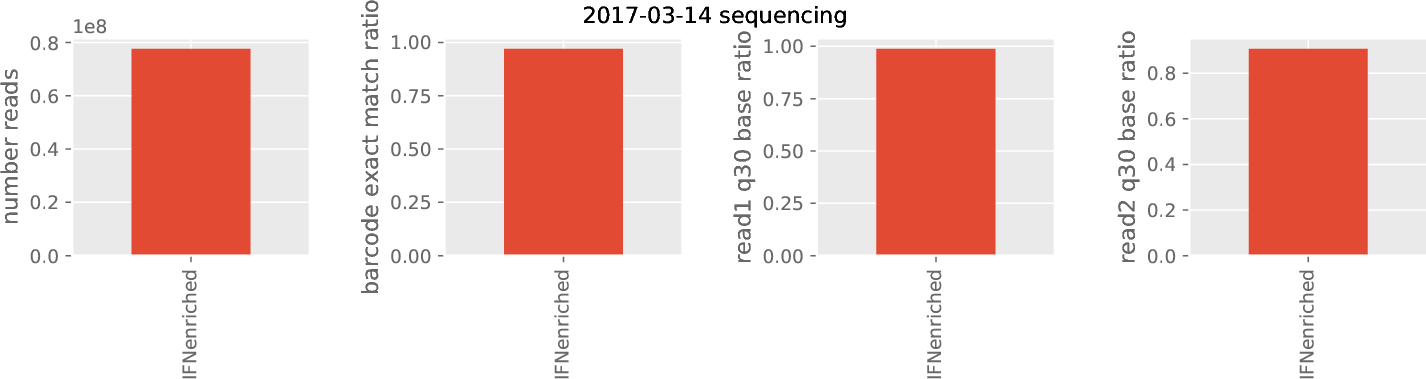

De-multiplexed reads for 2017-07-21 already in ./results/demultiplexed_reads/2017-07-21


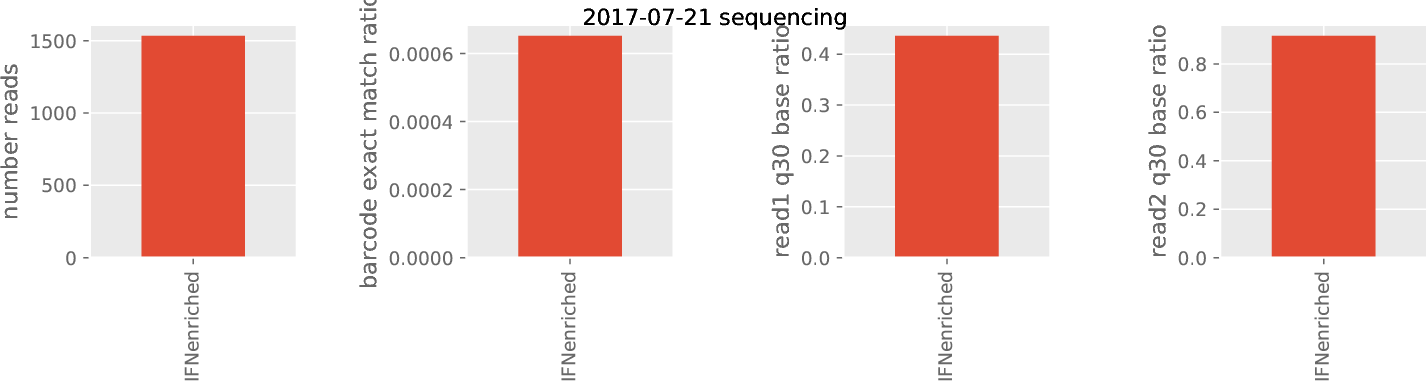

All de-multiplexing is complete.


In [5]:
demuxdir = os.path.join(resultsdir, 'demultiplexed_reads/')
if not os.path.isdir(demuxdir):
    os.mkdir(demuxdir)
    
for seqrun in seqruns:
    outdir = os.path.join(demuxdir, seqrun)
    qcplot = os.path.join(plotsdir, '{0}_demux.pdf'.format(seqrun))
    
    if os.path.isdir(outdir):
        print("De-multiplexed reads for {0} already in {1}".format(seqrun, outdir))
    else:
        print("De-multiplexing {0} into {1}...".format(seqrun, outdir))
        samplesheet = os.path.join(demuxdir, '{0}_samplesheet.csv'.format(seqrun))
        with open(samplesheet, 'w') as f:
            f.write(bcl_samplesheets[seqrun])
        flowcell = flow_cells[seqrun]
        mro = '__{0}.mro'.format(flowcell)
        
        # run cellranger, move output files to outdir, delete unneeded output
        log = !(cellranger mkfastq --run={bcl_dirs[seqrun]} --output-dir={outdir} \
                --csv={samplesheet} --project=fastq {mask[seqrun]} \
                && mv {mro} {outdir} && mv {flowcell} {outdir}/pipestance) || \
                (rm -r {outdir} && rm {mro} rm -r {flowcell})
                
    qc = os.path.join(outdir, 'pipestance/outs/qc_summary.json')
    if not os.path.isfile(qcplot):
        pymodules.utils.demuxSummary(qc, qcplot, '{0} sequencing'.format(seqrun))
    pymodules.utils.showPDF(qcplot)
    
print("All de-multiplexing is complete.")

The plots above summarize the de-multiplexing.
For all of these samples, the barcode match and Q30 values look good, so sequencing itself seems successful.

## Align the reads and count the genes per cell
We use `cellranger count` to align the reads to the reference genome and classify the reads into cells.
Because our samples are spread over multiple flow cells, we have to use MRO files to tell `cellranger` to combine these [as described here](https://support.10xgenomics.com/single-cell/software/pipelines/latest/advanced/multi-flowcell).

We also copy the resulting cell-gene counts to a separate subdirectory so that they are easy to find and modify subsequently below.

Finally, we print the links to the `cellranger` websummary pages, and make some plots summarizing the results.

Alignments and counts already created for IFNenriched in ./results/./alignments_and_counts/IFNenriched
The cellranger web summary for this IFNenriched is in ./results/./plots/cellranger_web_summary_IFNenriched.html

Here is a plot summarizing the results:


/home/jbloom/.local/lib/python3.4/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


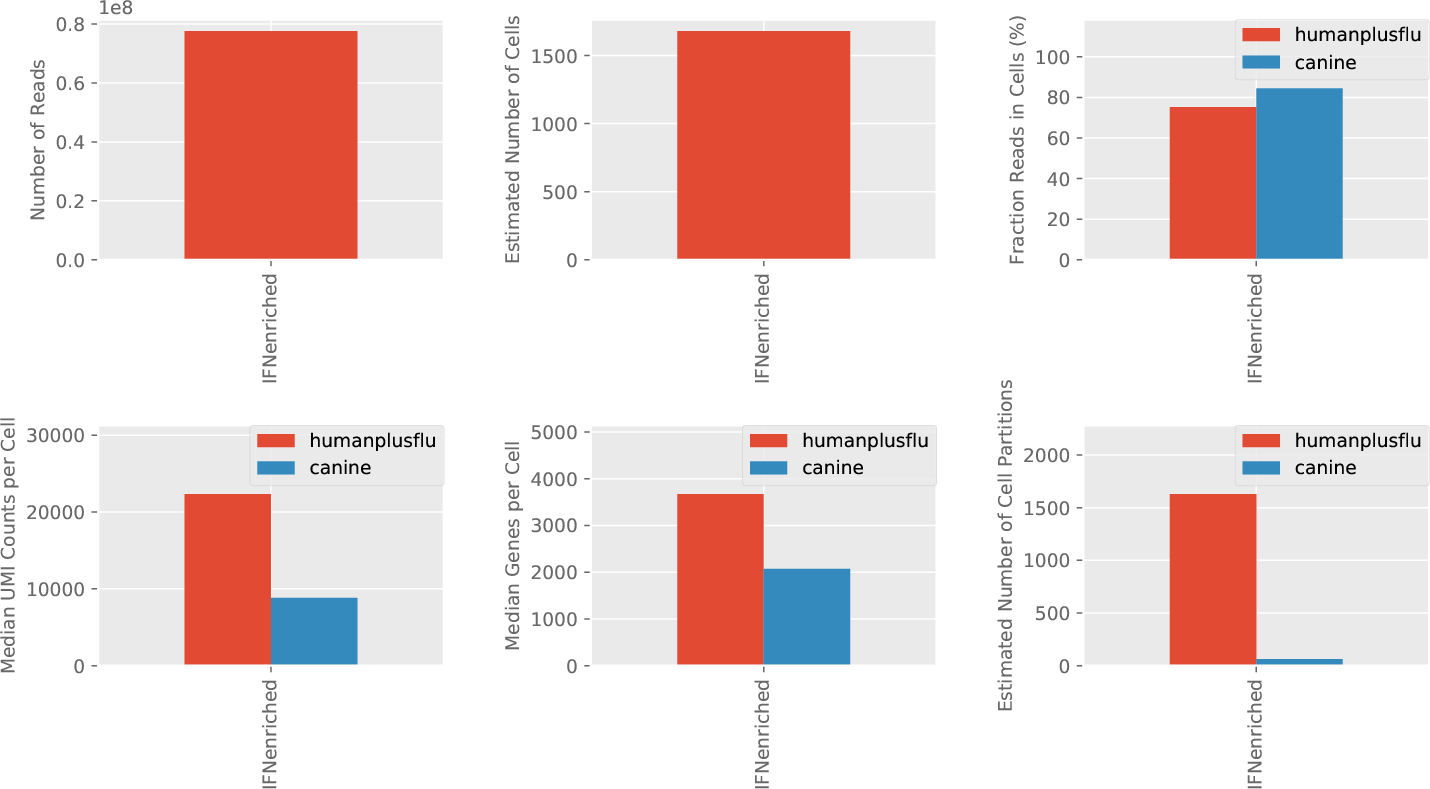

In [13]:
aligndir = os.path.join(resultsdir, './alignments_and_counts/')
if not os.path.isdir(aligndir):
    os.mkdir(aligndir)
    
countsdir = os.path.join(resultsdir, './cellgenecounts/')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
      
alignmetrics = []
cellgene_d = dict([(ftype, {}) for ftype in ['matrix', 'genes', 'barcodes']])
counts = {} # directory with cellgenecounts for each sample
bamfiles = {} # BAM files for each sample, used to annotate synonymous barcodes

for sample in samples:
    
    # process the reads for the sample
    sample_demuxdirs = [os.path.join(demuxdir, seqrun, 'fastq') for 
            seqrun in seqruns_for_sample[sample]]
    outdir = os.path.join(aligndir, sample)
    websummary = os.path.join(plotsdir, 'cellranger_web_summary_{0}.html'.format(sample))
    
    if os.path.isdir(outdir):
        print("Alignments and counts already created for {0} in {1}".format(sample, outdir))
    else:
        print("Making alignments and counts for {0}...".format(sample))
        mro = '_{0}_cellrangercount.mro'.format(sample)
        with open(mro, 'w') as f:
            f.write(pymodules.utils.multiFlowCellMRO(sample, sample_demuxdirs, refgenome))
        log = !cellranger count {sample} {mro} --localcores={maxcpus} --nosecondary && mv {sample} {outdir} \
                && rm {mro}
        assert os.path.isdir(outdir)
        print("Alignments and counts for {0} now in {1}".format(sample, outdir))
        
    if not os.path.isfile(websummary):
        shutil.copy(os.path.join(outdir, 'outs', 'web_summary.html'), websummary)
    assert os.path.isfile(websummary), "Can't find {0}".format(websummary)
    print("The cellranger web summary for this {0} is in {1}".format(sample, websummary))
    
    bamfiles[sample] = os.path.join(outdir, 'outs/possorted_genome_bam.bam')
    counts[sample] = os.path.join(countsdir, sample)
    if not os.path.isdir(counts[sample]):
        os.mkdir(counts[sample])
    for f in ['matrix.mtx', 'genes.tsv', 'barcodes.tsv']:
        fullf = os.path.join(counts[sample], 'humanplusflu_{0}'.format(f))
        cellgene_d[os.path.splitext(f)[0]][sample] = fullf
        if not os.path.isfile(fullf):
            shutil.copy(os.path.join(outdir, 'outs', 'filtered_gene_bc_matrices', 
                    'humanplusflu', f), fullf)
    alignmetrics.append(os.path.join(outdir, 'outs', 'metrics_summary.csv'))

print("\nHere is a plot summarizing the results:")
countsummaryplot = os.path.join(plotsdir, 'align_and_count_summary.pdf')

pymodules.utils.countSummary(samples, alignmetrics, countsummaryplot,
        celltypes=['humanplusflu', 'canine'])
pymodules.utils.showPDF(countsummaryplot)

These summaries show that all samples have between 3000 and 4000 cells, which is as expected.

We see that most reads successfully map to cells, and that the mean UMI counts per cell vary a bit, mostly based on sequencing depth per cell (there are more sequences per cell for some of the samples).

Overall, these summaries appear to indicate that everything worked well.

## Annotate synonymous barcodes on the influenza reads
The cells were infected with a mix of wildtype virus and virus carrying a synonymous barcode (two synonymous mutations) so that they would appear near the 3' end of the mRNA and frequently be read in the 10X sequencing.

However, the `cellranger` analysis does not annotate those barcodes, so we do that here with a custom Python script.

In [ ]:
synbarcodeplots = os.path.join(plotsdir, './synbarcodes/')
if not os.path.isdir(synbarcodeplots):
    os.mkdir(synbarcodeplots)

cellgene_d['annotations'] = {} 

for sample in samples:
    barcodes = os.path.join(counts[sample], 'humanplusflu_barcodes.tsv')
    annotations = os.path.join(counts[sample], 'humanplusflu_cellannotations.tsv')
    cellgene_d['annotations'][sample] = annotations
    outprefix = os.path.join(synbarcodeplots, '{0}_'.format(sample))
    if os.path.isfile(annotations):
        print("Synonymous barcodes on influenza reads already annotated for {0}".format(sample))
    else:
        print("Annotating synonymous barcodes on influenza reads for {0}".format(sample))
        log = !python scripts/annotate_synbarcodes.py --flugenes \
                data/flu_sequences/flu-wsn.fasta --synflugenes \
                data/flu_sequences/flu-wsn-syn.fasta --samplename {sample} \
                --outprefix {outprefix} --cellbarcodes {barcodes} --bamfiles \
                {bamfiles[sample]} && mv {outprefix}cellannotations.tsv {annotations}
    assert os.path.isfile(annotations), "Can't find {0}".format(annotations)

print("\nHere are some summary plots:")
for plot in ['umistats', 'purity']:
    outplot = os.path.join(plotsdir, 'synbarcodes_{0}.jpg'.format(plot))
    pymodules.utils.tilePlots([os.path.join(synbarcodeplots, '{0}_{1}.pdf'.format(
            sample, plot)) for sample in samples], outplot, ncols=3)
    display(Image(outplot))
    shutil.copy(outplot, figsdir)

From these plots we see several things:

  1. First, we are able to call the synonymous barcodes in about half of the influenza UMIs from the 10X whole-transcriptome sequencing. This is about as expected -- sometimes these barcodes won't be overlapped by the Illumina read, and so won't be callable. 
  
  2. The number of influenza UMIs is about as expected. These numbers are zero for the *Uninfected* cells, very low for the *6hr* infection, low for the *8hr* infections, and moderate for the *10hr* infection.
  
  3. In all populations, we find a mix of the wildtype and synonymous barcoded viruses. In cells with low numbers of reads, these are about equal in frequency indicating that we are just seeing leakage. But in cells with more reads, the cells are mostly of one type or the other -- indicating that the actual rate of co-infection is low.

## Build merged cell-gene matrix suitable for loading into Monocle
We merge all of the samples into a single cell-gene matrix file, and also make merged genes and cell annotation files giving the rows and columns.
These cell-gene matrices and their annotations are appropriate for analysis with `Monocle`.

In [ ]:
print("Building cell-gene matrix that merges all samples...")
mergedcounts = dict([(os.path.splitext(ftype)[0], os.path.join(countsdir, 
        'merged_humanplusflu_{0}'.format(ftype))) 
        for ftype in ['genes.tsv', 'cells.tsv', 'matrix.mtx']])
if all(map(os.path.isfile, mergedcounts.values())):
    print("The merged files already exist: {0}".format(', '.join(mergedcounts.values())))
else:
    pymodules.utils.mergeCellGeneMatrices(
            mergedcounts['genes'],
            mergedcounts['cells'],
            mergedcounts['matrix'],
            samples,
            cellgene_d['barcodes'],
            cellgene_d['annotations'],
            cellgene_d['genes'],
            cellgene_d['matrix'],
            )
    assert all(map(os.path.isfile, mergedcounts.values()))
    print("Created merged files: {0}\n".format(', '.join(mergedcounts.values())))